# HW 1 Report
### EE 399 Machine Learning for Science and Engineering

Completed by: Ewan Lister on 04/10/2023

https://github.com/ewan-lister/EE-399


## Abstract

Machine Learning often assumes the guise of a complex and mystical form of CS sorcery, but this is just isn't the case. This assignment seeks to simplify concepts of Machine Learning by presenting one of its key methods--**curve fitting**. From small to large systems, curve fitting entails creating a model, and then minimizing the error found between that model and the actual sampled data. In this assignment, we will give an in depth coverage of the theory behind curve fitting, demo some code for fitting sampled data, present results, and evaluate our methods and error. 

## I. Introduction and Overview

Curve fitting is a ubiquitous tool used in virtually all fields of science and engineering. Typically, it seeks to find continuous approximations for data that is noisy, discrete, has a low sampling rate, or where the driving variables behind the data are unknown. By collecting data and then generating a curve fit, scientists and engineers can determine whether new models describe natural phenomena, diagnose error associated with measurement, and even overturn existing scientific models. Curve fitting does not do all the work for us, however. The technique has the caveat that we ourselves must propose a model for fitting. For example, by definition a linear fit would return a completely different function than a radical fit, meaning we would draw totally different conclusions from the data. Systems in nature do not uniformly act in terms of one elementary function. There is much variety, so we must select our idea of what the fit is, and then let the computer do the work.

We will begin by covering the theoretical background of curve fitting, discussing the data, model, metric, and fitting techniques. Then, we will develop an algorithm for fitting multiple different curves to a series of data. After plotting our results, we will discuss the fits made by the algorithm and the margin of error. Finally, we will conclude with a discussion of the implications this method had for the assignment and in general.


In [2]:
# import useful math and plotting libraries
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

## II. Theoretical Background

The fundamental unit of consideration in curve fitting is the **model**. A model can be thought of as some sort of black box, which receives inputs, and produces outputs, similar to a function. In fact, we will use function notation to represent the models discussed from hereon. Say we want a general function which accurately describes most models.

$$ Y = F(X, \theta) $$  

In the above equation, we have a function which relates the set of input measurements $X$ to the set of output measurements using the function $F(X, \theta)$, which is a function of some sort of expression of $X$ as well as an additional set of constants $\theta$, which are called **parameters**.  If we wanted a model which described a cartesian line, we would propose the model $Y = \theta_{0}X + \theta_{1}$. For those familiar with basic algebra, $\theta_{0}$ is the slope of the line, and $\theta_{1}$ is the y-intercept. Instead of labeling these constants as $m$ and $b$, we choose to express the parameters found in this model, and all models, as some parameter $\theta_{n}$. This is because in the theory of machine learning, one may encounter models with trillions of parameters, and it is not feasible to associate individually significant identities with each parameter. Thus in general, one should begin to think of all models as mathematical expressions of $X$, peppered with $\theta s$.

If curve fitting is to be useful beyond the 2d world, then one must also be able to construct functions that receive multiple inputs, and produce multiples outputs. There are many systems in our world where the state of the system is highly multidimensional e.g vision, personal data,  so it is also necessary to think of $Y$ and $X$ not as measurements of a single variable, but as sets of measurements of multiple variables.

Returning to the line example, let's understand what qualifies a good fit for data. Shown below are a set of points, and a line drawn through them.

Text(0.5, 0, 'x')

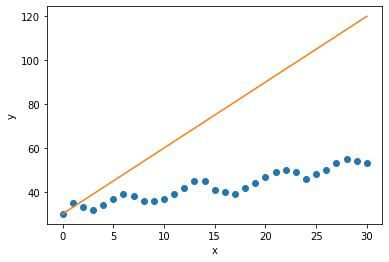

In [22]:
# define data
X = np.arange(0,31)
Y = np.array([30, 35, 33, 32, 34, 37, 39, 38, 36, 36, 37, 39, 42, 45, 45, 41,
     40, 39, 42, 44, 47, 49, 50, 49, 46, 48, 50, 53, 55, 54, 53])

# number of inputs
num_in = len(Y)

line = np.add(3 * X, 30)
plt.plot(X, Y,'o')
plt.plot(X, line)
plt.ylabel('y')
plt.xlabel('x')

This function $y = 3x + 30$ tries, but according to any reasonable perspective, fails to fit the data. Why is it so obvious that it fails? It has a lot to do with how close the y values expressed by the line model are to the actual data. Compare this with a model of decent fit to the data:

Text(0.5, 0, 'x')

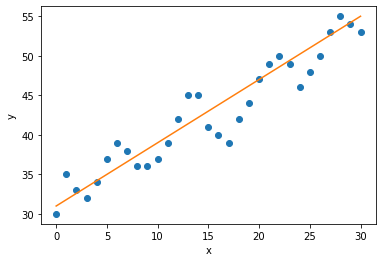

In [23]:
line_2 = np.add(0.80 * X, 31)

plt.plot(X, Y,'o')
plt.plot(X, line_2)
plt.ylabel('y')
plt.xlabel('x')


The $y$ values expressed by the fit $y = 0.8x + 31$ are much closer to that of the data, but exactly how should we quantify this closeness? The concept that we use to measure the accuracy of our fit is known as the **metric**. A metric can be any equation which relates the behavior of the model to the behavior of the data. Conveniently, statistics provides us with an equation which is useful for relating variant quantities (such as a model and its data), the standard deviation equation. Substituting in the error for the standard deviation, we can create an accurate metric for evaluating our models:

$$ E = \sqrt{\frac{1}{n} \sum_{k = 1}^n (F(x_k, \theta) - y_k)^2}$$

The result of this equation $E$ is equal to the total error between the model and the set of values $y_k$ which we chose to compare. It is not possible to construct a model which would produce the maximum error, as the amount of error can be infinite, and in any case, we are focused on finding a model that has minimum error in relation to the data. Visiting again on our high school calculus, one may recall that there is a function called the derivative, which returns the rate of change of an expression with respect to a variable. Wherever the rate of change is 0, the function is at a minimum or maximum. Our error function, when the model parameters are unknown, is purely a function of the parameters $\theta$ when all of the other data is know. So what happens if we take the partial derivatives $\frac{\delta E}{\delta\theta}$ and $\frac{\delta E}{\delta\theta}$. Wherever these values equal 0, there is a minimum, and wherever global minimum is, is the best fit for our model.

It is impractical for us to take the derivative of large models, and near impossible to solve a nonlinear set of equations proposed by the derivative of the error metric using traditional $Ax = b$ approaches. Therefore, in this assignment we use a lesser known approach for finding minima called the Nelder-Mead technique. We will not cover the technique in depth, but in short, the technique uses an n-dimensional triangle on the topology created by the error metric. Each vertex of the triangle is located at some coordinate of the parameters and the error $(E, \theta_{n},...,\theta_{n})$. By algorithmically moving the vertices of the triangle down or across the topology, we can eventually arrive at a good local minimum. 

In order to achieve good starting conditions for the Nelder-Mead method, we must also have a good idea of the range in which our desired minima sits, so a favorable approach might be to consider a reasonable range in which the parameters lie (this range is a function of the data), and then to simply generate random starting parameters within that range, and initiate the Nelder-Mead algorithm to isolate a minimum.

With the above theoretical framework, we can now begin to curve fit the data using other non-linear models.

## III. Algorithm Implementation and Development 

Consider the data from lecture on 3/31:

     X=np.arange(0,31)
     Y=np.array([30, 35, 33, 32, 34, 37, 39, 38, 36, 36, 37, 39, 42, 45, 45, 41,
     40, 39, 42, 44, 47, 49, 50, 49, 46, 48, 50, 53, 55, 54, 53])

Fit data to a least squares metric, and this model: $ f(x) = A\cos{Bx} + Cx + D$ 

### (i) Write a code to find the minimum error and determine the parameters A,B,C,D.

We now have the opportunity to implement our proposed model and error metric, as python functions which accept the data.

In [24]:
# proposed fit for data
# accepts input value as well as models parameters (floats)
def model_1(x, c):
    y = c[0] * np.cos(c[1] * x) + (c[2] * x) + c[3]
    return y

# defines the objective function for optimization
def error(c, x, y, num_in):
    e2 = np.sqrt((np.sum(model_1(x, c) - y) ** 2) / num_in)
    return e2


These methods can be called to calculate modeled $y$ values based on the sampled $x$ values, which we can then use in our `error` function. Now we must create an initial set of constants. Notice that the constants are represented by values within the `c0` array.

In [25]:
# set the initial guess for the parameters
c0 = np.array([4, np.pi/3.5, 0.6, 29])

This guess is based on the fact that our model has 4 parameters, the average height of the sinusoidal figure is around 4, the frequency of the figure is some function of $\pi$, and line underlying the figure seems to have a small slope and an intercept around 30. This sort of thinking is what one may need to do to begin guessing correct fits for models (but random trial and error is also possible). Now that we have a set of constants we can use it as an initial guess for the Nelder-Mead method, and plot the results.

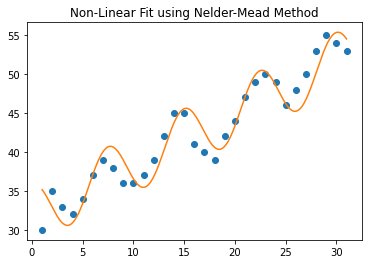

In [26]:
# perform optimization
res = opt.minimize(error, c0, args=(np.arange(1,num_in + 1), Y, num_in), method='Nelder-Mead')

# get the optimized parameters
c = res.x

# generate the data for plotting
tt = np.arange(1, num_in + 0.01, 0.01)
yfit = (c[0]*np.cos(c[1]*tt)+(c[2] * tt) + c[3])

# plot the raw data and the fitted curve
plt.plot(np.arange(1, num_in + 1), Y, 'o', label='data')
plt.plot(tt, yfit, label='fit')
plt.title('Non-Linear Fit using Nelder-Mead Method')
plt.show()


Not so bad right? These techniques really can be used to produce good fits, but it is necessary to combine trial and error with intelligent guesswork. The next question demonstrates a technique that helps provide clues to the human eye for minima.

### (ii) With the results of (i), fix two of the parameters and sweep through values of the other two parameters to generate a 2D loss (error) landscape. Do all combinations of two fixed parameters and two swept parameters. You can use something like pcolor to visualize the results in a grid. How many minima can you find as you sweep through parameters?

Color maps are incredibly useful because they give us humans the opportunity to see some of the space that our optimization algorithm is traversing. By sweeping two parameters, and holding the others fixed, we take a slice of the space, one that may contain useful minima. We can begin constructing this colormap by modularizing our curve fitting function into `fit_data_f1(num_in, c0, Y)`.

In [27]:
# condense previous operations into a single function fit_data_f1 for usage in proceeding
# exercizes
def fit_data_f1(num_in, c0, Y):
    # perform optimization
    res = opt.minimize(error, c0, args=(np.arange(1,num_in + 1), Y, num_in), method='Nelder-Mead')
    # get the optimized parameters
    c = res.x
    # generate the data for plotting
    tt = np.arange(1, num_in + 0.01, 0.01)
    yfit = (c[0]*np.cos(c[1]*tt)+(c[2] * tt) + c[3])
    # plot the raw data and the fitted curve
    plt.plot(np.arange(1, num_in + 1), Y, 'ko')
    plt.plot(tt, yfit, 'r-')
    plt.show()


This will make it much easier to repeatedly fit curves to our data. Note that `X` is not an input to the function because `X` is simply the integer enumeration from 0 to 30, which is easy to produce and thus doesn't need to take up space as a function argument. To create a colormap we should also specify a few plotting parameters, such as the size of the map, granularity, and the parameters we are sweeping. For convenience sake, we will also re-choose our initial guess.

In [28]:
# manipulate c0 once more
c0 = np.array([5, np.pi/5, 1, 83])

plot_dim = 100
plot_granularity = 1 # 10 gradations per integer
par = [1, 3]


Next we need a function which will plot a colormap using array data, as well as a function which creates an array of values on the swept/fixed parameters as well as the error metric.

In [32]:
# accepts a 2d array of floats
# plots array as a color map
def plot_color(e1_array, par):
    label = 'Error Metric under Swept Parameters ' + str(par[0]) + ' and ' + str(par[1])
    plt.pcolormesh(e1_array)
    plt.title(label)
    plt.xlabel('C' + str(par[0]))
    plt.ylabel('C' + str(par[1]))
    plt.show()


# accepts: model parameters c0 (list of floats)
# list of idex of parameters to be swept (list of int)
# inputs and outputs of data (lists of floats)
# additionally accepts array_dim and array_granularity
# for determining dimensions of returned array and fineness
# of array
# returns: an array containing the error of a model
# as a function of swept parameters
def sweep_parameters(c0, par, inputs, outputs, plot_dim, plot_granularity):
    dim = plot_dim * plot_granularity
    # first set up function which creates an array
    error_array = np.zeros((dim, dim))

    num_in = len(inputs)
    # iterates through zero array and initializes with swept value of error
    # function, where chosen parameters par[0] and par[1] are x and y respectively
    with np.nditer(error_array, flags=['multi_index'], op_flags=['writeonly']) as it:
        for space in it:
            [x, y] = it.multi_index
            c0[par[0]] = y / plot_granularity
            c0[par[1]] = x / plot_granularity
            space[...] = error(c0, inputs, outputs, num_in)
    return error_array


`plot_color(e1_array, par)` uses the matplotlib library function `colormesh` inorder to convert an array into a visible 2d color graph, where the shade of the color represents how high or low the error value is. The function `sweep_parameters(c0, par, inputs, outputs, plot_dim, plot_granularity)` allows us to propose a set of parameters, choose which ones we want to sweep, and edit colormap specifications. Calling these two functions for the parameters `c[1]` and `c[3]` produces the following graph.

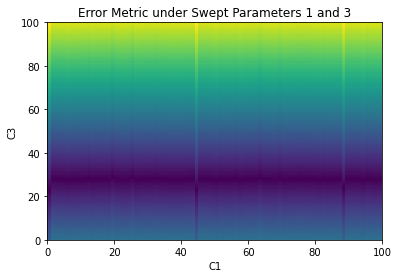

In [34]:
# calculate error_array
error_array = sweep_parameters(c0, par, X, Y, plot_dim, plot_granularity)

# plot color map of error array
plot_color(error_array, par)

In the plot we can see a very deep purple low error zone, perhaps corresponding to a useful value for C3, and for C1 there are groups of periodic bands, which makes sense given that C3 affects the model sinusoidally. With information like this, we can make a more educated guess about our initial parameters.

**Ans:** Upon complteting (ii), I discovered numerous minima. Ultimately, the number of minima depend in part on the landscape in which the fixed minima localize the swept minima. 

### (iii) Using the first 20 data points as training data, fit a line, parabola and 19th degree polynomial to the data. Compute the least-square error for each of these over the training points. Then compute the least square error of these models on the test data which are the remaining 10 data points.

In the following code snippet, we define several more functions to make fitting more convenient, such as defining functions `line` and `n_poly` to refer to our specific models (if you think about it, a parabola is just a 2 degree polynomial). We then plot the results, this is an instance of extrapolational projection, where we are trying to create a model for data outside the range of fitter data.

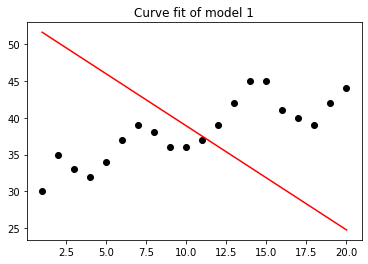

Error for linear fit on 20 points: 6.338482718837875
Error for linear fit on disjoint 10 points: 10.739199478459685


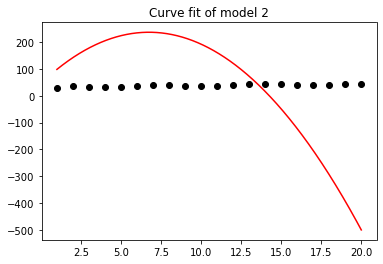

Error for parabola fit on 20 points: 121.71479506472724
Error for linear fit on dijoint 10 points: 412.58556954093547


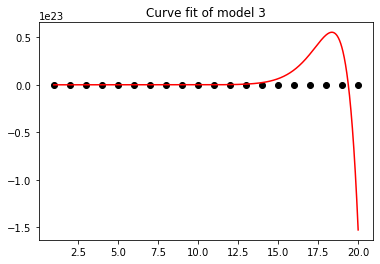

Error for 19 degree polynomial fit on 20 points: 3.334788483493379e+22
Error for linear fit on disjoint 10 points: 6.220311080595841e+17


In [42]:
# initialize new data
X_0 = X[:20]
X_comp = np.arange(0, 10)
Y_0 = Y[0:20]
Y_comp = Y[20:30]

# define functions which can be adjusted to calculate least-square error
# for multiple models.

# models for line, and nth degree polynomial (also applicable for parabola)
def line(x, c):
     y = c[0] * x + c[1]
     return y

# need to revise to apply to array of x's instead of single value
def n_poly(x, c, degree):
     length = len(x)
     y = np.zeros(length)
     terms = len(c)
     powers = np.arange(degree, -1, -1, dtype=int)
     for index in range(length):
          inputs = np.ones(terms) * x[index]
          y[index] = single_poly(c, powers, inputs)
     return y 

def single_poly(c, powers, inputs):
     var = np.power(inputs, powers)
     expr = np.multiply(var, c)
     y = np.sum(expr)
     return y


# multiplexer for choosing different f_theta(x) models
def model_sel(model, x, c):
     parabola_deg = 2
     n_deg = 19
     if model == 0:
          output = model_1(x, c)
     elif model == 1: 
          output = line(x, c)
     elif model == 2:
          output = n_poly(x, c, parabola_deg)
     elif model == 3:
          output = n_poly(x, c, n_deg)
     else:
          print("Unknown model number. Please try again.")
     return output

# calculates least-squares error of model versus data
# models: 0 - model_1, 1 - line, 2 - parabola, 3 - 19 degree polynomial
def error_modular(c, x, y, model):
     input_size = len(x)
     e2 = np.sqrt((np.sum(model_sel(model, x, c) - y) ** 2) / input_size)
     return e2

def fit_data(c0, Y, model):
     num_in = len(Y)
     # perform optimization
     res = opt.minimize(error_modular, c0, args=(np.arange(1,num_in + 1), Y, model), method='Nelder-Mead')
     # get the optimized parameters
     c = res.x
     # generate the data for plotting
     tt = np.arange(1, num_in + 0.01, 0.01)
     yfit = model_sel(model, tt, c)
     # plot the raw data and the fitted curve
     plt.plot(np.arange(1, num_in + 1), Y, 'ko')
     plt.plot(tt, yfit, 'r-')
     plt.title('Curve fit of model ' + str(model))
     plt.show()
     return c

# generates size array of random constants taken from normal distribution
def seed(size):
     return np.random.rand(1, size) * 50

# generate random starting parameters
line_c = seed(2)
par_c = seed(3)
poly_c = seed(20)

# print line fit and error
line_fit = fit_data(line_c, Y_0, 1)
line_error_1 = error_modular(line_fit, X_0, Y_0, 1)
line_error_2 = error_modular(line_fit, X_comp, Y_comp, 1)
print('Error for linear fit on 20 points: ' + str(line_error_1))
print('Error for linear fit on disjoint 10 points: ' + str(line_error_2))

# print parabola fit and error
par_fit = fit_data(par_c, Y_0, 2)
par_error_1 = error_modular(par_fit, X_0, Y_0, 2)
par_error_2 = error_modular(par_fit, X_comp, Y_comp, 2)
print('Error for parabola fit on 20 points: ' + str(par_error_1))
print('Error for linear fit on dijoint 10 points: ' + str(par_error_2))

# print 19 degreee polynomial fit and error
poly_fit = fit_data(poly_c, Y_0, 3)
poly_error_1 = error_modular(poly_fit, X_0, Y_0, 3)
poly_error_2 = error_modular(poly_fit, X_comp, Y_comp, 3)
print('Error for 19 degree polynomial fit on 20 points: ' + str(poly_error_1))
print('Error for linear fit on disjoint 10 points: ' + str(poly_error_2))

### (iv) Repeat (iii) but use the first 10 and last 10 data points as training data. Then fit the model to the test data (which are the 10 held out middle data points). Compare these results to (iii)

In this section, we use the same methods, but employ interpolational projection, where we are trying to project data within the range of the fitted data.


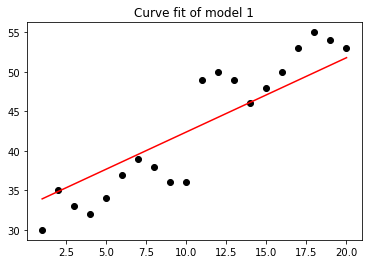

Error for linear fit on 20 points: 18.90496676976723
Error for linear fit on disjoint middle 10 points: 16.467818341474146


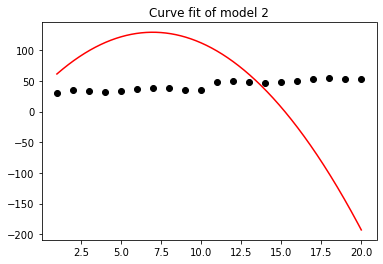

Error for parabola fit on 20 points: 1165.4352648588006
Error for linear fit on dijoint middle 10 points: 110.3039677722613


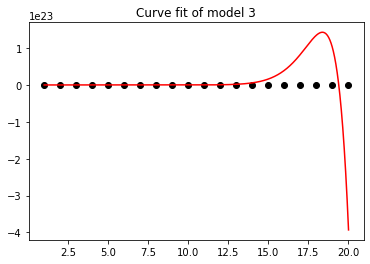

Error for 19 degree polynomial fit on 20 points: 4.2228042362387726e+27
Error for linear fit on disjoint middle 10 points: 1.2118081748387336e+23


In [44]:
# initialize new data
X_1 = np.concatenate([X[:10], X[-10:]])
X_comp_1 = X[10:20]
Y_1 = np.concatenate([Y[:10], Y[-10:]])
Y_comp_1 = Y[10:20]

# generate random starting parameters
line_c = seed(2)
par_c = seed(3)
poly_c = seed(20)

# print line fit and error
line_fit = fit_data(line_c, Y_1, 1)
line_error_1 = error_modular(line_fit, X_1, Y_1, 1)
line_error_2 = error_modular(line_fit, X_comp_1, Y_comp_1, 1)
print('Error for linear fit on 20 points: ' + str(line_error_1))
print('Error for linear fit on disjoint middle 10 points: ' + str(line_error_2))

# print parabola fit and error
par_fit = fit_data(par_c, Y_1, 2)
par_error_1 = error_modular(par_fit, X_1, Y_1, 2)
par_error_2 = error_modular(par_fit, X_comp_1, Y_comp_1, 2)
print('Error for parabola fit on 20 points: ' + str(par_error_1))
print('Error for linear fit on dijoint middle 10 points: ' + str(par_error_2))

# print 19 degreee polynomial fit and error
poly_fit = fit_data(poly_c, Y_1, 3)
poly_error_1 = error_modular(poly_fit, X_1, Y_1, 3)
poly_error_2 = error_modular(poly_fit, X_comp_1, Y_comp_1, 3)
print('Error for 19 degree polynomial fit on 20 points: ' + str(poly_error_1))
print('Error for linear fit on disjoint middle 10 points: ' + str(poly_error_2))

### IV. Computational Results

The techniques used above had some efficacy in computing a best fit for the data initially proposed. However, when we did not fit the model which appears closest to the actual distribution of the data $ f(x) = A\cos{Bx} + Cx + D$, the error went way up. This is reasonable, as there was really only one correct model for the data. What is very interesting, is how in part (ii), there is greater error for the unfit data, and in part (iii) there is less error for the unfit data than the fitted data. This is an example of the effectiveness of curve fits for extrapolational versus interpolational modeling. Due to the high variability of subsequent data, it is actually really difficult to create models that can predict outliers or any values which are found out of the range of the data. On the other hand, curve fitting is very good at interpolating data, or finding values that may exist within the range of the data.

Overall, more iterative techniques, which try multiple cases would help our fits to be more accurate.

### V. Summary and Conclusions

In conclusion, this tutorial has provided an overview of curve fitting and its applications. We have learned that the fundamental unit of consideration in curve fitting is the model, which can be thought of as a black box that receives inputs and produces outputs. We have discussed how to represent models using function notation, where the model is a function of input measurements and a set of parameters that describe the relationship between inputs and outputs.

We have also discussed the importance of constructing functions that receive multiple inputs and produce multiple outputs to model systems with multiple variables. Additionally, we have explored how color maps can be used to visualize the optimization process and identify useful minima in the space of parameters.

Through our discussion of theoretical background and algorithm implementation, we have learned how to use Python libraries like NumPy and SciPy to fit curves to data and make predictions. We have also covered practical considerations such as overfitting, regularization, and extrapolation.

In summary, curve fitting is a powerful technique for approximating the underlying relationship between input and output variables in a dataset. By understanding the fundamentals of curve fitting and utilizing Python libraries, we can accurately fit curves to data and make predictions in a variety of settings. This tutorial serves as a starting point for further exploration into the theory and practice of curve fitting.